In [37]:
import dataIO_funcs
# from datetime import datetime
import datetime
import numpy as np
import dateutil.parser
import os
import subprocess
from snowexsql.db import get_db
from snowexsql.data import LayerData,PointData,ImageData# Import the function to get connect to the db
from snowexsql.conversions import query_to_geopandas # Import a useful function to format that data into a dataframe 
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString, Polygon
import folium
import matplotlib.pyplot as plt
# import this to use define sql functions (e.g. postgis!)
from sqlalchemy.sql import func 
from geoalchemy2.types import Raster
import geoalchemy2.functions as gfunc
from  snowexsql.data import SiteData
from snowexsql.conversions import raster_to_rasterio 
import rioxarray as rxr
import xarray as xr


In [2]:
# EXPLAIN ALL THE DATA INPUTS, & HOW THE NOTEBOOK IS ORGANIZED

In [3]:
# specify paths
bucket_name = 'eis-dh-hydro/SNOWEX-HACKWEEK'
LIS_path = f's3://{bucket_name}/2022/ZARR/SURFACEMODEL/LIS_HIST_default_chunks.d01.zarr/'
# LIS_path = f's3://{bucket_name}/2022/ZARR/SURFACEMODEL/LIS_HIST_rechunkedV4.d01.zarr'
SWESARR_url = 'https://glihtdata.gsfc.nasa.gov/files/radar/SWESARR/prerelease/'

# SWESARR data website
source_repo = 'https://glihtdata.gsfc.nasa.gov/files/radar/SWESARR/prerelease/'

# specify filters
time_sel='2020-02-08'
lat_range = [39.01629, 39.02229]
lon_range = [-108.21, -108.175]
model_variable = ['SM_SWE_inst','SM_SnowDepth_inst']
dx = 0.0011
dy = 0.0009
time_buffer_dy = 2

db_name = 'snow:hackweek@db.snowexdata.org/snowex' # This is what you will use for all of hackweek to access the db
type_name = 'point'
var_name = 'depth'


In [4]:
map=folium.Map(location=[np.mean(lat_range), np.mean(lon_range)],
               zoom_start=11,name = 'Esri Satellite',)

north = lat_range[1]
south = lat_range[0]
east = lon_range[1]
west = lon_range[0]

#adding lines connecting the markers
loc_1 = [(north, west),(north, east)]
loc_2 = [(south, west),(south, east)]
loc_3 = [(north, west),(south, west)]
loc_4 = [(south, east),(north, east)]

folium.PolyLine(loc_1,color='blue',weight=2,opacity=0.8).add_to(map)
folium.PolyLine(loc_2,color='blue',weight=2,opacity=0.8).add_to(map)
folium.PolyLine(loc_3,color='blue',weight=2,opacity=0.8).add_to(map)
folium.PolyLine(loc_4,color='blue',weight=2,opacity=0.8).add_to(map)

map

In [5]:
# ADD AN IMAGE SHOWING THE SATELLITE IMAGERY FOR THIS DOMAIN AS WELL!

In [6]:
# ADD A CELL EXPLAINING THE LIS DATA DOWNLOAD
# EXPLAIN HOW COOL ESMF IS

In [7]:
buffer = 0.001
lat_range_LIS = [lat_range[0]-buffer,lat_range[1]+buffer]
lon_range_LIS = [lon_range[0]-buffer,lon_range[1]+buffer]
ds_LIS = dataIO_funcs.access_LIS(lon_range_LIS,lat_range_LIS,time_sel,
                             model_variable,LIS_path,dx,dy,'bilinear')

In [8]:
# ADD A CELL EXPLAINING THE SNOWEX POINT DATA DOWNLOAD

In [9]:
df_Points,polygon = dataIO_funcs.access_snowEx.access_pointData(db_name,time_sel,time_buffer_dy,var_name,lat_range,lon_range)

(datetime.date(2020, 2, 8),)
(datetime.date(2020, 2, 9),)
(datetime.date(2020, 2, 6),)
(datetime.date(2020, 2, 10),)
(datetime.date(2020, 2, 7),)
[[-108.21, 39.01629], [-108.175, 39.01629], [-108.175, 39.02229], [-108.21, 39.02229]]


In [10]:
# this takes a little while because you can't filter the query by location (e.g. lat/lon??)
# ds_Lidar = dataIO_funcs.access_snowEx.access_layerData(b_name,time_sel,time_buffer_dy,var_name,lat_range,lon_range)

ds_Lidar = rxr.open_rasterio('raster_depth.tif')
ds_Lidar_reproj = ds_Lidar.rio.reproject(4326)
poly_WGS = polygon.to_crs("EPSG:4326")
ds_Lidar_reproj = ds_Lidar_reproj.rio.clip(poly_WGS.geometry)
ds_Lidar_regrid = ds_Lidar.rio.reproject_match(ds_LIS)

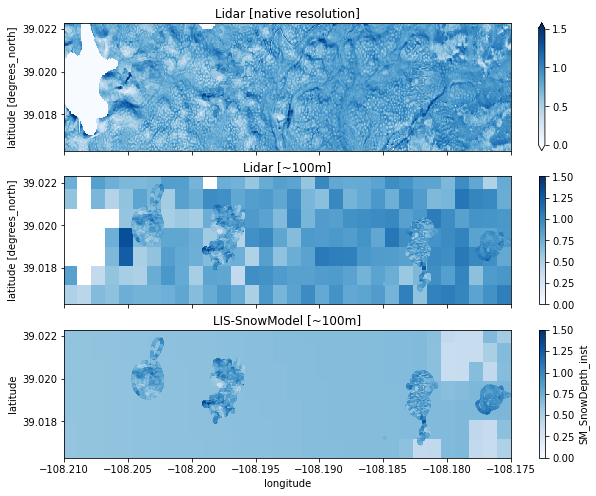

In [11]:
varbl = 'SM_SnowDepth_inst'
minval = 0
maxval = 1.5
mpr = 'Blues'
title_list = ['Lidar [native resolution]','Lidar [~100m]','LIS-SnowModel [~100m]']

fg,ax = plt.subplots(3,1,figsize=(10,8))
ax = np.ravel(ax)

ds_Lidar_reproj.plot(ax=ax[0],vmin=minval,vmax=maxval,cmap=mpr)
ds_Lidar_regrid.plot(ax=ax[1],vmin=minval,vmax=maxval,cmap=mpr)
ds_LIS[varbl].plot(ax=ax[2],vmin=minval,vmax=maxval,cmap=mpr)

df_Points_reproject = df_Points.to_crs(4326)

for axcount,axx in enumerate(ax):
    axx.scatter(df_Points_reproject.geometry.x,df_Points_reproject.geometry.y,4,df_Points_reproject.value/100,
              vmin=minval,vmax=maxval,cmap='Blues')
    axx.set_xlim(lon_range)
    axx.set_ylim(lat_range)
    axx.set_title(title_list[axcount])
    if axcount < 2:
        axx.set_xlabel('')
        axx.set_xticklabels('')


In [45]:
x_indexer = xr.DataArray(df_Points_reproject.geometry.x,dims=["point"])
y_indexer = xr.DataArray(df_Points_reproject.geometry.y,dims=["point"])

ds_Lidar_reproj_vals = ds_Lidar_reproj.sel(x=x_indexer, y=y_indexer, method="nearest")
ds_Lidar_regrid_vals = ds_Lidar_regrid.sel(x=x_indexer, y=y_indexer, method="nearest")
ds_LIS_vals = ds_LIS[varbl].sel(longitude=x_indexer, latitude=y_indexer, method="nearest")

In [53]:
df_Points_reproject['diff_Lidar'] = np.ravel(ds_Lidar_reproj_vals.values)-(df_Points_reproject.value/100)
df_Points_reproject['diff_Lidar_regrid'] = np.ravel(ds_Lidar_regrid_vals.values)-(df_Points_reproject.value/100)
df_Points_reproject['diff_LIS'] = np.ravel(ds_LIS_vals.values)-(df_Points_reproject.value/100)

Text(0, 0.5, 'Snow depth difference [m; gridcell-point')

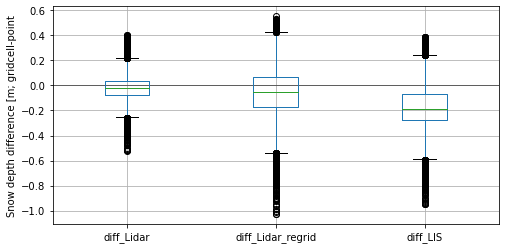

In [61]:
fg,ax = plt.subplots(figsize=(8,4))
ax.plot([0.5,3.5],[0,0],'-k',linewidth=0.5)
df_Points_reproject.boxplot(column=['diff_Lidar','diff_Lidar_regrid','diff_LIS'],ax=ax)
ax.set_ylabel('Snow depth difference [m; gridcell-point')

[[-108.21, 39.01629], [-108.175, 39.01629], [-108.175, 39.02229], [-108.21, 39.02229]]


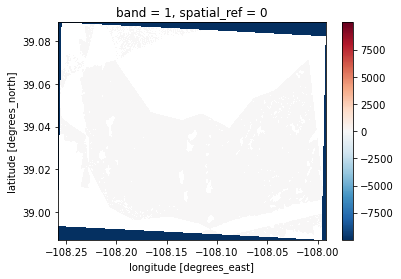

In [5]:
# this takes a little while because you can't filter the query by location (e.g. lat/lon??)
# ds_Lidar = dataIO_funcs.access_snowEx.access_layerData(b_name,time_sel,time_buffer_dy,var_name,lat_range,lon_range)

ds_Lidar = rxr.open_rasterio('raster_depth.tif')
ds_Lidar_reproj = ds_Lidar.rio.reproject(4326)
ds_Lidar_reproj.plot()

# list of coordindate pairs
coordinates = [[ lon_range[0], lat_range[0] ], [ lon_range[1], lat_range[0] ], [ lon_range[1], lat_range[1]], [lon_range[0], lat_range[1]]]        
print(coordinates)
# Create a Shapely polygon from the coordinate-tuple list
ply_coord = Polygon(coordinates)
# create a dictionary with needed attributes and required geometry column
df = {'Attribute': ['name1'], 'geometry': ply_coord}
# Convert shapely object to a geodataframe 
poly = gpd.GeoDataFrame(df, geometry='geometry', crs ="EPSG:4326")

poly.geometry

# geodf = geopandas.read_file(...)
# xds = rioxarray.open_rasterio(...)
clipped = ds_Lidar_reproj.rio.clip(poly.geometry)


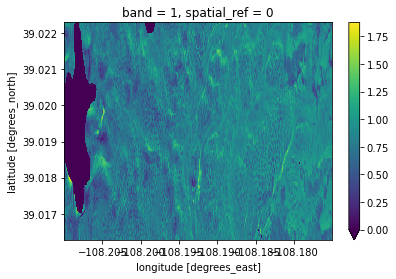

In [8]:
clipped.plot(vmin=0)

In [ ]:
# site_name = 'Grand Mesa'
# collection_date = date(2020, 2, 13)
# # Remember in the query parentheses is what we get back, in this case were asking for the raster data as a geotiff
# result = session.query(func.ST_AsTiff(gfunc.ST_Union(ImageData.raster, _type=Raster))).filter(SiteData.site_name == site_name).filter(ImageData.date == collection_date).filter(ImageData.instrument == 'lidar').filter(ImageData.type == 'depth')

/tmp/ipykernel_3936/483347798.py:1: SAWarning: SELECT statement has a cartesian product between FROM element(s) "public.points" and FROM element "public.layers".  Apply join condition(s) between each element to resolve.
  q.all()


In [ ]:
DO LIDAR DOWNLOAD HERE, SAVE THE LIDAR SO WE HAVE THIS AT THE SAME RESOLUTION AS WELL

In [ ]:
THEN, DO THE POINT DOWNLOAD HERE

In [ ]:
RUBBER MEETS THE ROAD! INTERACTIVE PLOT SHOWING THE 1) NATIVE-RES LIDAR, 2) REGRIDDED LIDAR
3) MODEL OUTPUT (EACH OF THOSE THREE HAVE THE FIELD CAMPAIGN OVER IT)

In [ ]:
USE VALERIE SCRIPT TO DO DATA COMPARISON!

(39.01629, 39.02229)

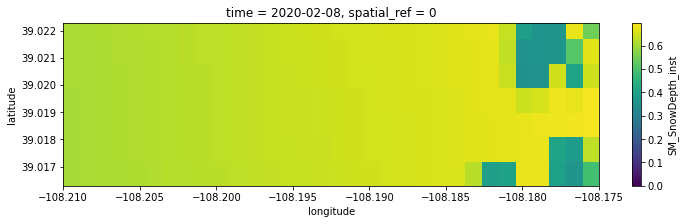

In [55]:
fg,ax = plt.subplots(figsize=(12,3))
ds_LIS['SM_SnowDepth_inst'].plot(ax=ax)
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)

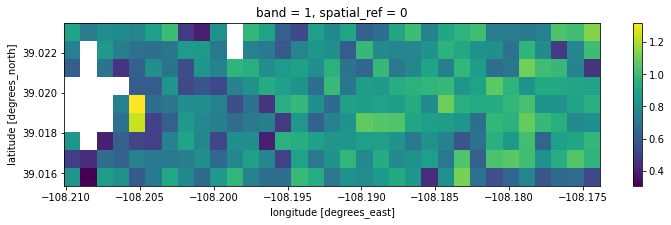

In [103]:
# show both comparisons (before/after reprojections)

import rioxarray as rxr
ds2 = rxr.open_rasterio('raster_depth.tif')
fg,ax = plt.subplots(figsize=(12,3))

outt = ds2.rio.reproject_match(ds_LIS)
outt.plot(ax=ax)
# (outt-ds_LIS['SM_SnowDepth_inst']).plot(ax=ax)

In [56]:
def date_between_prime_snowEx(start_date, end_date, folder_date):
    result = [folder_date[i] for i in range(len(folder_date)) if (folder_date[i].date >= start_date and folder_date[i].date <= end_date)]
    return result

In [106]:
# open the session
time_buffer_dy = 0
var_name = 'depth'

engine, session = get_db(db_name)

# do date filtering
pointDates = session.query(PointData.date).distinct().all()

time_sel_newForm = dateutil.parser.parse(time_sel)
start_date = time_sel_newForm-datetime.timedelta(days=time_buffer_dy)
start_date = start_date.date()
end_date = time_sel_newForm+datetime.timedelta(days=time_buffer_dy)
end_date = end_date.date()

filtered_dates = date_between_prime_snowEx(start_date, end_date, pointDates)

# query the dataset and concatenate
q = session.query(PointData).filter(PointData.type == var_name)   

data_day_list = []
for dt_count,dtt in enumerate(filtered_dates):
    print(dtt)
    dt_sel = datetime.date(dtt[0].year,dtt[0].month,dtt[0].day)
    q_sub = q.filter(PointData.date == dt_sel)
    df = query_to_geopandas(q_sub, engine)

    # i think this is what you do to concatenate??
    data_day_list.append(df)
df_concat = pd.concat(data_day_list)
df_concat_gpd = gpd.GeoDataFrame(df_concat)

session.close()

# list of coordindate pairs
coordinates = [[ lon_range[0], lat_range[0] ], [ lon_range[1], lat_range[0] ], [ lon_range[1], lat_range[1]], [lon_range[0], lat_range[1]]]        
print(coordinates)
# Create a Shapely polygon from the coordinate-tuple list
ply_coord = Polygon(coordinates)
# create a dictionary with needed attributes and required geometry column
df = {'Attribute': ['name1'], 'geometry': ply_coord}
# Convert shapely object to a geodataframe 
poly = gpd.GeoDataFrame(df, geometry='geometry', crs ="EPSG:4326").to_crs("EPSG:26912")
df_clipped = gpd.clip(df_concat_gpd, poly)

(datetime.date(2020, 2, 8),)
[[-108.21, 39.01629], [-108.175, 39.01629], [-108.175, 39.02229], [-108.21, 39.02229]]


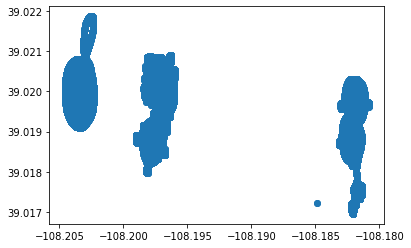

In [114]:
plt.scatter(df_clipped.longitude,df_clipped.latitude)

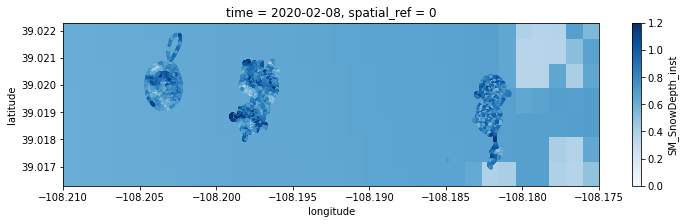

In [107]:
df_reproj = df_clipped.to_crs("EPSG:4326")
vvmin = 0
vvmax = 1.2

fg,ax = plt.subplots(figsize=(12,3))
out = ds_LIS['SM_SnowDepth_inst'].plot(vmin=vvmin,vmax=vvmax,
                                       cmap='Blues',ax=ax)
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)

ax.scatter(df_reproj.geometry.x,df_reproj.geometry.y,4,df_reproj.value/100,
          vmin=vvmin,vmax=vvmax,cmap='Blues')



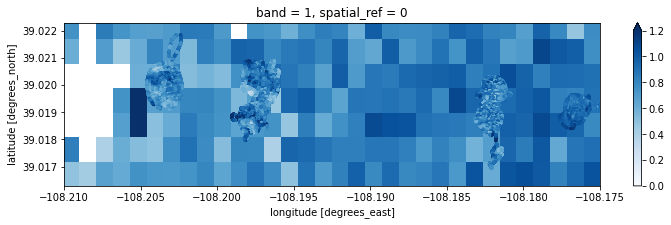

In [105]:
vvmin = 0
vvmax = 1.2

fg,ax = plt.subplots(figsize=(12,3))
outt.plot(vmin=vvmin,vmax=vvmax,cmap='Blues',ax=ax)
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)

ax.scatter(df_reproj.geometry.x,df_reproj.geometry.y,4,df_reproj.value/100,
          vmin=vvmin,vmax=vvmax,cmap='Blues')

In [ ]:
df = dataIO_funcs.access_snowEx.access_pointData(db_name,time_sel,time_buffer_dy,var_name,lat_range,lon_range)

# FOR PULLING SWESARR
#### TAKES A LOOK AT ALL OF THE DATA AVAILABLE, THEN ATTAEMPTS TO PULL THE DATA THAT IS 'TIME_BUFFER_DY' FROM THE SPECIFIED DAY 'TIME_SEL'

In [3]:
# pull the dates that SWESARR occurred
dataIO_funcs.access_SWESAR
SWESARR_names,SWESARR_dates = dataIO_funcs.access_SWESARR.get_url_paths(SWESARR_url)
print(SWESARR_names)

AttributeError: module 'dataIO_funcs' has no attribute 'access_SWESAR'

In [13]:
def date_between_prime(start_date, end_date, folder_date,folder_names):
    result = [folder_names[i] for i in range(len(folder_date)) if (folder_date[i] >= start_date and folder_date[i] <= end_date)]
    return result
time_sel_newForm = dateutil.parser.parse(time_sel)
start_date = time_sel_newForm-datetime.timedelta(days=time_buffer_dy)
end_date = time_sel_newForm+datetime.timedelta(days=time_buffer_dy)

final_files = date_between_prime(start_date, end_date, SWESARR_dates, SWESARR_names)
for flight_line in final_files:
    print(source_repo + flight_line)
    # command = wget -r -np -nH --reject "indexd.html*" -e robots=off -r --no-parent -A "*tif" source_repo + flight_line
    subprocess.Popen(['wget -r -np -nH --reject indexd.html* -e robots=off -r --no-parent -A *tif',source_repo+flight_line], shell=True)
    # ! wget -r -np -nH --reject "indexd.html*" -e robots=off -r --no-parent -A "*tif" source_repo + flight_line
    
data_files = []
os.chdir(os.getcwd() + flight_line)
for file in glob.glob("*.tif"):
    data_files.append(file)
    
data_files = [data for data in data_files if data[-8:] != '_dem.tif']

https://glihtdata.gsfc.nasa.gov/files/radar/SWESARR/prerelease//GRMCT2_13802_20006_012_200210_225_XX_01/
https://glihtdata.gsfc.nasa.gov/files/radar/SWESARR/prerelease//GRMCT2_31601_20006_011_200210_225_XX_01/
https://glihtdata.gsfc.nasa.gov/files/radar/SWESARR/prerelease//GRMNT1_09302_20006_009_200210_225_XX_01/
https://glihtdata.gsfc.nasa.gov/files/radar/SWESARR/prerelease//GRMNT1_09401_20006_005_200210_225_XX_01/
https://glihtdata.gsfc.nasa.gov/files/radar/SWESARR/prerelease//GRMST1_27302_20006_007_200210_225_XX_01/
https://glihtdata.gsfc.nasa.gov/files/radar/SWESARR/prerelease//GRMST1_27501_20006_003_200210_225_XX_01/


wget: missing URL
Usage: wget [OPTION]... [URL]...

Try `wget --help' for more options.
wget: missing URL
Usage: wget [OPTION]... [URL]...

Try `wget --help' for more options.
wget: missing URL
Usage: wget [OPTION]... [URL]...

Try `wget --help' for more options.
wget: missing URL
Usage: wget [OPTION]... [URL]...

Try `wget --help' for more options.
wget: missing URL
Usage: wget [OPTION]... [URL]...

Try `wget --help' for more options.
wget: missing URL
Usage: wget [OPTION]... [URL]...

Try `wget --help' for more options.


FileNotFoundError: [Errno 2] No such file or directory: '/home/jovyan/model-eval/contributors/jupflug/GRMST1_27501_20006_003_200210_225_XX_01/'

# LIS MODEL READ-IN
#### READS IN THE DATA BASED ON THE LAT/LON/DATE CONSTRAINTS, PROVIDED THE MODEL VARIABLES OF FOCUS
#### WE ALSO GIVE IT THE APPROXIMATE MODEL DX AND DY WE WANT TO MOVE TO WHEN CONVERTING TO A RECTANGULAR GRID

In [3]:
ds_LIS = dataIO_funcs.access_LIS(lon_range,lat_range,time_sel,
                             model_variable,LIS_path,dx,dy,'bilinear')

In [3]:
ds_LIS

NameError: name 'ds_LIS' is not defined

# POINT AND LAYER DATA READ-IN

In [3]:
df = dataIO_funcs.access_snowEx.access_pointData(db_name,time_sel,time_buffer_dy,var_name,lat_range,lon_range)

(datetime.date(2020, 2, 8),)
(datetime.date(2020, 2, 9),)
(datetime.date(2020, 2, 6),)
(datetime.date(2020, 2, 10),)
(datetime.date(2020, 2, 7),)
[[-107.7, 38.8], [-107.5, 38.8], [-107.5, 38.9], [-107.7, 38.9]]


In [26]:
df

{'Attribute': ['name1'],
 'geometry': <shapely.geometry.polygon.Polygon at 0x7fa4e9abb550>}

In [24]:
engine, session = get_db(db_name)
pointDates = session.query(ImageData.date).distinct().all()


In [25]:
pointDates

[(None,),
 (datetime.date(2020, 2, 13),),
 (datetime.date(2020, 2, 21),),
 (datetime.date(2020, 2, 12),),
 (datetime.date(2020, 1, 31),),
 (datetime.date(2020, 2, 1),),
 (datetime.date(2020, 2, 2),),
 (datetime.date(2020, 3, 11),)]